# Semantic Segmentation DataLoader

> 下面是语义分割DataLoader制作方法，以后都以此为模板制作语义分割DataLoader，以传统U-Net制作为例

In [1]:
import torch.utils.data as data
import torch
from torchvision import transforms
from PIL import Image
import os
import numpy as np

- 首先是获取路径，这里建议直接用**相对路径转绝对路径，否则listdir会不起作用**
- 然后再用一个迭代求出每个图片的绝对路径

In [2]:
img_file=os.path.abspath("../Data/membrane/train/image/")
label_file=os.path.abspath("../Data/membrane/train/label")

img_name=os.listdir(img_file)
img_list=[img_file+'\\'+str for str in img_name]

label_name=os.listdir(label_file)
label_list=[label_file+'\\'+str for str in label_name]

开始制作数据集，制作数据集本质其实就是继承Dataset类，但是有几点是需要注意的:
- 一般我们是在`__getitem__`里面定义对图片的转换和操作，最后在这个函数里面返回结果。
- 有时候图片处理过程比较繁琐，直接写在`__getitem__`可能会比较麻烦，可以在这里另外定义静态方法
- 如果处理并不是很复杂，还是可以直接用transform来处理的，写在函数外，但是不是很建议，有时候图像处理是很复杂的，没有必要用管道方法处理，写另外函数处理更加方便
- 读取图片时候，已经不建议用`PLT`这种图像处理库了，应该使用`skimage`这种专门用来读取机器学习图像的库，直接读出来就是数组形式的，非常方便
- 还有一件事，如果是RGB图片，读取出来的数组的形状是H×W×C，所以我们一般需要把C换到第一，所以要用`tranpose(2,0,1)`

In [3]:
from skimage import io
import numpy as np
import matplotlib as plt

一定要注意标准化图片

In [4]:
img=io.imread(img_list[0])

#因为标签是0和1，所以我们要标准化
img=img/255

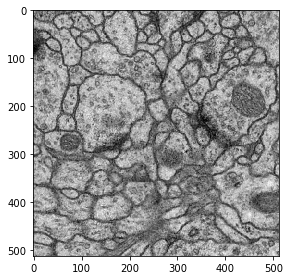

In [5]:
io.imshow(img)

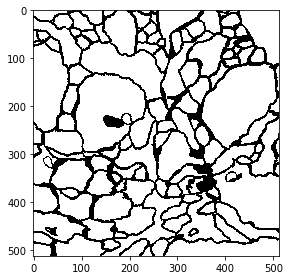

In [6]:
label=io.imread(label_list[0])
io.imshow(label)

In [7]:
#标准化图片
label=label/255

**标签0，1这种，必须转化为long，而不是float**

In [8]:
#将图片转换为tensor
ff=torch.as_tensor(img.copy()).float().contiguous()
label=torch.as_tensor(label.copy()).long().contiguous()

下面来看一下建立的具体过程

In [9]:
from torch.utils.data import Dataset
import torch.nn as nn

In [10]:
class MyDataSet(Dataset):
    
    #一开始需要什么参数一般就是几个，文件列表，如何处理
    def __init__(self,img_list,label_list) -> None:
        super().__init__()
        self.img_list=img_list
        self.label_list=label_list
    
    #__getitem__方法比较难写，那就放最后，每个写方法，都要记得加self，这里不是C++，不会默认传指针的
    def __len__(self):
        return len(self.img_list)

    #需要复杂处理，单独写静态方法处理比较好，因为我这里处理简单，只是用来示范，不用加标志区分img和label。而且处理过程最好在外部试一下
    @staticmethod
    def preprocess(img):
        img=img/255
        return img
    
    def __getitem__(self, index):
        
        img=io.imread(self.img_list[index])
        label=io.imread(self.label_list[index])
        
        img=self.preprocess(img=img)
        label=self.preprocess(label)
        
        #转为pytorch tensor，记得用copy()
        img_tensor=torch.as_tensor(img.copy()).float().contiguous()
        label_tensor=torch.as_tensor(label.copy()).long().contiguous()
        
        return img_tensor,label_tensor
           
        


我们用DataLoader来存储这个数据集，有利于我们训练，这是很方便的，因为这里用了多线程加速

In [11]:
from torch.utils.data import DataLoader
mydata=MyDataSet(img_list,label_list)
data=DataLoader(mydata,1,shuffle=True)

这里其实蛮麻烦的，DataLoader是一个可迭代对象，但是需要用`iter()`方法来转换为迭代器，才能用`next()`进行逐次迭代

In [12]:
test=iter(data)
next(test)

[tensor([[[0.3255, 0.2667, 0.2510,  ..., 0.2471, 0.2157, 0.2980],
          [0.3608, 0.1843, 0.1922,  ..., 0.2667, 0.4118, 0.3333],
          [0.4549, 0.3961, 0.4157,  ..., 0.2627, 0.3686, 0.4235],
          ...,
          [0.6196, 0.4549, 0.4078,  ..., 0.5451, 0.2000, 0.2471],
          [0.5216, 0.3922, 0.3961,  ..., 0.5882, 0.5333, 0.3255],
          [0.2941, 0.2863, 0.2863,  ..., 0.5725, 0.6314, 0.4000]]]),
 tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]])]

# 建立模型方法

模型一般要分文件夹写,结构如下
```
UNet
├─ model
│  └─ __init__.py
├─ train.py
└─ utils
   └─ __init__.py

```
这里模型下面有几个模块，每个文件夹都需要一个`__init__.py`，这是python规定:
- model：这个就是一些模型具体模块，比如主体和各种模块，举个例子，我们把encoder写一个文件，decoder模块写一个文件，然后特殊模块写一个文件，但是一般简单的比如我这个U-Net，一个文件足够了
- utils：这个就是一些小组件，比如损失函数，数据处理模块，评价模型函数和类可以写在这里
- train.py：这个就是训练模型的文件，其实还可以自己写一个评价模型的

具体模型怎么写，仔细看U-Net结构案例